In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [4]:
df = pd.get_dummies(df,columns=['Geography','Gender'],drop_first=True)

In [5]:
X = df.drop('Exited', axis=1)
y = df['Exited']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
class ChurnData(Dataset):
    def __init__(self, X_train, y_train) -> None:
        super().__init__()
        self.X = torch.from_numpy(X_train)
        self.y = torch.from_numpy(y_train)
        self.y = self.y.type(torch.LongTensor)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [9]:
churn_data = ChurnData(X_train.values, y_train.values)
train_loader = DataLoader(dataset=churn_data, batch_size=32)

In [10]:
print(f"X Shape: {churn_data.X.shape}, y shape: {churn_data.y.shape}")

X Shape: torch.Size([8000, 11]), y shape: torch.Size([8000])


In [11]:
class BinaryClassNN(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN_FEATURES):
        super().__init__()
        # layer 1
        self.lin1 = nn.Linear(NUM_FEATURES, HIDDEN_FEATURES)
        # layer 2
        self.lin2 = nn.Linear(HIDDEN_FEATURES, NUM_CLASSES)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
        return x

In [12]:
# hyperparamter
NUM_FEATURES = churn_data.X.shape[1]
HIDDEN = 3
NUM_CLASSES = len(churn_data.y.unique())

# create model instance
model = BinaryClassNN(NUM_FEATURES=NUM_FEATURES, NUM_CLASSES=NUM_CLASSES, HIDDEN_FEATURES=HIDDEN)

In [13]:
from torchsummary import summary

summary(model, input_size=(NUM_FEATURES,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              36
            Linear-2                    [-1, 2]               8
           Sigmoid-3                    [-1, 2]               0
Total params: 44
Trainable params: 44
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [14]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
for _, y in train_loader:
    print(y.dtype)
    break  # Remove this line if you want to see all batches

torch.int64


In [16]:
# training
NUM_EPOCHS = 25
losses = []
for epoch in range(NUM_EPOCHS):
    for x, y in train_loader:
        # convert input tensor to float32
        x = x.float()

        # convert target tensor to one-hot encoding
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=NUM_CLASSES).float()

        # initialize gradients
        optimizer.zero_grad()

        # forward pass
        y_hat_log = model(x)

        # calculate losses
        loss = criterion(y_hat_log, y_one_hot)

        # calculate gradients
        loss.backward()
        
        # update parameters
        optimizer.step()

    losses.append(float(loss.data.detach().numpy()))

<Axes: >

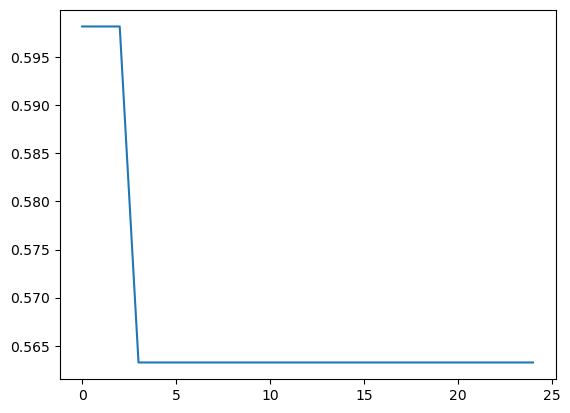

In [17]:
#show losses over epochs
sns.lineplot(x= range(len(losses)), y = losses)

In [18]:
X_test_torch = torch.from_numpy(X_test.values).float()
with torch.no_grad():
    y_test_hat_softmax = model(X_test_torch)
    y_test_hat = torch.max(y_test_hat_softmax.data, 1)
     

In [19]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_hat.indices.cpu().numpy())

0.798